In [1]:
import os
import subprocess
import time
import re
import numpy as np
import math
from os import listdir
from os.path import isfile, join

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

#import paramiko

from scipy.ndimage import imread
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import square, disk, dilation

from PIL import Image
import pandas as pd

from utils import read_tiff, make_dir, read_images_from_directory, smooth
from monitor_utils import *


Bad key "axes.color_cycle" on line 65 in
/users/opid19/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [190]:
#---------------------------
#   Colors
#---------------------------

blue = (57 / 255.0, 106 / 255.0, 177 / 255.0)
red = (204/ 255.0, 37/ 255.0, 41/ 255.0 )
green = (62/ 255.0, 150/ 255.0, 81/ 255.0 )  
grey = (128/ 255.0, 133/ 255.0, 133/ 255.0 )
gold = (237/ 255.0, 218/ 255.0, 116/ 255.0 )

#---------------------------
#   Fonts
#---------------------------

title_font_size = 20
label_font_size = 16
ticks_font_size = 16



def read_flow_from_components(file_u, file_v, shape):
    u = np.fromfile(file_u, dtype='float32', sep="")
    u = u.reshape(shape)
    
    v = np.fromfile(file_v, dtype='float32', sep="")
    v = v.reshape(shape)
    
    return u,v

def read_raw_image(file_name, shape):
    img = np.fromfile(file_name, dtype='float32', sep="")
    img = img.reshape(shape)
    
    return img
    

def read_raw_files_save_as_multitiff_stack(path, file_name, shape, mask=""):
    if mask == "":
        files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    else:
        files = sorted([f for f in listdir(path) if isfile(join(path, f)) and f.find(mask) != -1])
        
    #print('Number of images to convert:', len(files))
    
    imlist = []
    for f in files:
        #im = np.array(Image.open(p + f))
        #imlist.append(Image.fromarray(m))

        np_im = read_raw_image(path + f, shape)
        imlist.append(Image.fromarray(np_im))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])

    #print('OK')
    
def get_similar_flat(image, sigma):
    diff_values = []
    
    image_low_pass = gaussian_filter(image, sigma=sigma)
    
    ixgrid = np.ix_(range(0,image.shape[0],100),range(0,image.shape[1],100))
    
    for fl in flats_low_pass:
        diff_values.append(np.mean(np.abs(image_low_pass[ixgrid] - fl[ixgrid])))
        
    min_index = np.argmin(diff_values)
    
    return flats[min_index] 


def process_sequence():
    # Processing
    print('Dataset: {}'.format(dataset))
    print('Input file: {}'.format(file_name))
    print('Processing...')
    
    

    if clean:
        os.system('rm ' + output_path+'*')


    if use_adaptive_flats:
        # Get all flats
        sigma = 15          # sigma for low-pass filtering
        flat_num = 2       # number of flats prior to each shot

        # Extract flats (images before start index)
        for k in range(flats_start, flats_end+1):
            flats.append(images[k])
            flats_low_pass.append(gaussian_filter(images[k], sigma=sigma))

    for i in tqdm(range(start_spray, start_spray+seq_length)):
    #for i in range(start, end):

        # select frame
        frame_n = i

        im = images[frame_n]

        # Flat correction
        if use_adaptive_flats: 
            flat = get_similar_flat(im, sigma)
            im = np.log((flat.astype(float)  + 0.001) / (im.astype(float)  + 0.001))

        # Crop frame
        im = im[y0:y0+h, x0:x0+w]
        flat = flat[y0:y0+h, x0:x0+w]

        # Save input for procesing script (CUDA flow or corr)
        im_res = Image.fromarray(im)
        im.astype('float32').tofile(path_flow_input + input_frame_file)

        # Run processing for a single frame  
        command = [exec_path + corr_exec, path_flow_input + input_frame_file , str(w), str(h), str(i).zfill(3), output_path]
        #subprocess.check_output(command)
        subprocess.call(command)

        #print('Frame {0} '.format(i))

    # Collect results
    read_raw_files_save_as_multitiff_stack(output_path, output_path + dataset +'_amp_seq.tif', (h,w), 'corr-amp')
    read_raw_files_save_as_multitiff_stack(output_path, output_path + dataset +'_corr_seq.tif', (h,w), 'corr-coeff')

    print('Finished')
    
#----------------------------#
# Time analysis              #
#----------------------------#
def time_analysis(images, corr_images, cx, cy, rx, ry, y_pos=60, ax=None, region='all', show=False, color='k'):
    
    if  not ax:
        ax  = plt.subplot(111)

    #def avg_nonzero(a): 
    #    return np.mean(a[a > 0])

    all_shots_vel = []

    #for s in range(1):    
    for s in range(shots_num):
        # Get sequence for the shot
        seq = images[s*seq_length:(s+1)*seq_length]
        seq_corr = corr_images[s*seq_length:(s+1)*seq_length]

        mean_vel_values = []

        #for i in range(1):
        for i in range(seq_length): 

            im = seq[i][cy-ry:cy+ry,cx-rx:cx+rx]
            c = seq_corr[i][cy-ry:cy+ry,cx-rx:cx+rx]
            #print(cy-r_2, cx-r_2)

            # Filtering
            
            # 1. Put away large velocity outliers
            #filtered_amp = np.where(im < 10, im, 0)
            if filter_high:
                im = np.where(im < max_vel_in_pixels, im, 0)
            
                
            # 2. Drop velocities with low correlation values
            if filter_corr:
                filtered_corr = np.where(c > min_corr_value, 1, 0)
                im = im*filtered_corr
                #filtered_corr = 1.0
                
            # 3. Drop zero velocities from avareging
            if filter_zero:
                nonzero_values = im[im > min_vel_in_pixels]
                if len(nonzero_values) == 0:
                    im = 0.0
                else:
                    im = np.mean(nonzero_values)
            
                
            
            #amp_nonzeros_mean = np.mean(filtered_amp[filtered_amp > 0])
            if not (filter_high and filter_zero):
                im = np.mean(im)
                

            # Convert to m/s
            im = im*vel_factor
            #amp_nonzeros_mean = amp_nonzeros_mean*vel_factor

            mean_vel_values.append(im)
            #mean_vel_values.append(amp_nonzeros_mean)

        all_shots_vel.append(mean_vel_values)
        #ax.plot(mean_vel_values, linewidth=1.0, alpha=0.3)

    all_shots_mean = np.mean(np.array(all_shots_vel), axis=0)
    ax.plot(all_shots_mean, linewidth=2.0, color=color, linestyle='dashed')

    
    ax.set_title('Velocity evolution, region: ' + region, size=title_font_size)
    
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0, (0+seq_length)+1, 5)*sample_rate / 1000.0]
    x_ticks = np.arange(0, seq_length+1, 5)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_lables, fontsize = ticks_font_size)
    
    ax.set_ylabel('velocity, [m\s]', size=label_font_size)
    ax.set_xlabel('time from injection, [s]', size=label_font_size)


    overall_mean = np.mean(all_shots_mean)
    overall_std = np.std(all_shots_mean)

    #print('Overall average in region {0:.2f} m/s'.format(overall_mean))
    #print('Overall variation in region {0:.2f} m/s'.format(overall_std))
    #print('Variation in percent {0:.1f} %'.format(overall_std / overall_mean * 100))
    
    ax.text(1, y_pos, 'Mean: {0:.2f} m/s'.format(overall_mean), fontsize=14, color=color)
    ax.text(26, y_pos, 'STD: {0:.2f} m/s'.format(overall_std), fontsize=14, color=color)

    ax.set_ylim(vel_min,vel_max)
    ax.yaxis.set_tick_params(labelsize=label_font_size)
    
    if show:
        plt.show()
        
    return overall_mean, overall_std

def avg_nonzero(a): 
    
    non_zero_vals = a[a > min_vel_in_pixels]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.mean(non_zero_vals)
    

def make_analysis_figure():
    # Read dataset

    #start = time()
    images = read_tiff(output_path + dataset +'_amp_seq.tif', max_read_images)
    corr   = read_tiff(output_path + dataset +'_corr_seq.tif', max_read_images)

    #end = time()
    #print ('Time elapsed: ', (end-start))

    #------------------------------
    # Start analysis
    #------------------------------

    print('Analysis...')

    # Make masking
    med = np.median(images, axis=0)  
    thres = np.where(med > 5, 255.0, 0.0)
    dilated = dilation(thres, disk(6))
    mask = gaussian_filter(dilated, 3.5) 
    im_res = Image.fromarray(mask)
    im_res.save(results_path + '_mask.tif')

    # Mean velocity without any filtering
    amp_mean = np.mean(images, axis=0)
    im_res = Image.fromarray(amp_mean*vel_factor)
    im_res.save(results_path + '_amp_mean_nofilter.tif')

    # Filtering according to physical contraints

    filtered_amp = np.where(images < max_vel_in_pixels, images, 0)
    #filtered_amp = images # no filtering
    #filtered_amp = np.where(np.abs(images) < 10, images, 0) # Filter y-components
    filtered_corr = np.where(corr > min_corr_value, 1, 0)
    #filtered_corr = 1.0
    filtered_amp = filtered_amp*filtered_corr

    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    im_res = Image.fromarray(amp_filtered_mean*vel_factor)
    im_res.save(results_path + '_amp_mean_filter.tif')

    measure_name = 'Mean filtered velocity'
    measure_file = 'amp_mean_filter'

    pano = amp_filtered_mean*vel_factor

    amp_seq = images


    # Setup figure
    fig = plt.figure(1)

    fig.set_size_inches(20/3 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(3, 1, height_ratios=[1.3,1,1])

    #-------------------------------------------
    # Figure 1: Velocity maps
    #-------------------------------------------

    # Setup figure
    ax0 = plt.subplot(gs[0,:])

    imx = ax0.imshow(pano, vmin=vel_min, vmax=vel_max, cmap='inferno')
    ax0.set_title('Dataset: '+ dataset +', '+ measure_name, size=title_font_size, y=1.05)    
    ax0.set_xlabel('distance, [mm]', size=label_font_size)
    ax0.set_ylabel('distance, [mm]', size=label_font_size)

    width = pano.shape[1]
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, width+1, 100.0) /1000.0*pixel_size]
    
    x_ticks = np.arange(0, width+1, 100)
    ax0.set_xticks(x_ticks)
    ax0.set_xticklabels(x_lables, fontsize = ticks_font_size)

    height = pano.shape[0]

    
    y_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, height+1, 100.0) /1000.0*pixel_size]
    y_ticks = np.arange(0, height+1, 100)
    ax0.set_yticks(y_ticks)
    ax0.set_yticklabels(y_lables)

    ax0.yaxis.set_tick_params(labelsize=label_font_size)

    axins0 = inset_axes(ax0,
                       width="1.5%",  # width = 10% of parent_bbox width
                       height="100%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=ax0.transAxes,
                       borderpad=0                    
                       )

    # Separation lines between combined images

    clb = plt.colorbar(imx, cax=axins0)
    clb.ax.tick_params(labelsize=ticks_font_size)

    #step = int(350 / 2)
    step = int(250 / 2)

    ax0.axvline(step*1,linewidth=2, color=blue, alpha=0.7)
    ax0.axvline(step*2,linewidth=2, color=red, alpha=0.7)
    ax0.axvline(step*3,linewidth=2, color=green, alpha=0.7)


    # Create a Rectangle patch
    rect1 = patches.Rectangle((step*1 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=blue,facecolor='none', alpha=1.0)
    ax0.add_patch(rect1)

    rect2 = patches.Rectangle((step*2 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
    ax0.add_patch(rect2)

    rect3 = patches.Rectangle((step*3 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=green,facecolor='none', alpha=1.0)
    ax0.add_patch(rect3)

    ax0.grid(False)

    #plt.show()
    #fig.savefig(path + dataset + '_comb_' + measure[1] + '_map.png')


    #-------------------------------------------
    # Figure 2: Velocity profiles
    #-------------------------------------------

    plt.style.use('seaborn')

    #fig.set_size_inches(25, 8, forward=True)
    #plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

    data = pano

    smooth_mask = 4

    # Subplot 2
    vel_profile_A = data[:,step*1]
    vel_profile_B = data[:,step*2]
    vel_profile_C = data[:,step*3]

    np.savetxt(results_path + '_vel_profile_A.txt', vel_profile_A, fmt='%.5f')
    np.savetxt(results_path + '_vel_profile_B.txt', vel_profile_B, fmt='%.5f')
    np.savetxt(results_path + '_vel_profile_C.txt', vel_profile_C, fmt='%.5f')

    ax1 = plt.subplot(gs[1,0])
    ax1.set_title('spray region: '+region, size=title_font_size)
    ax1.plot(smooth(vel_profile_A, smooth_mask, 'flat'), linewidth=1.5, color=blue)
    ax1.plot(smooth(vel_profile_B, smooth_mask, 'flat'), linewidth=1.5, color=red)
    ax1.plot(smooth(vel_profile_C, smooth_mask, 'flat'), linewidth=1.5, color=green)
    ax1.set_ylim(vel_min, vel_max)
    ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
    ax1.set_xlabel('distance, [mm]', size=label_font_size)
    ax1.set_xticks(y_ticks)
    ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
    ax1.yaxis.set_tick_params(labelsize=label_font_size)


    #-------------------------------------------
    # Figure 3: Velocity time evolution
    #-------------------------------------------

    # Subplot 2
    ax4 = plt.subplot(gs[2,0])
    avg_vel_A, std_vel_A = time_analysis(amp_seq, corr, int(width/4), int(height/2), rx, ry, vel_min +25, ax4, region=region, show=False, color=blue)
    avg_vel_B, std_vel_B = time_analysis(amp_seq, corr, int(width/2), int(height/2), rx, ry, vel_min +15, ax4, region=region, show=False, color=red)
    avg_vel_C, std_vel_C = time_analysis(amp_seq, corr, int(3*width/4), int(height/2), rx, ry, vel_min +5, ax4, region=region, show=False, color=green)


    #all_results_path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\analysis_all_results\\'

    fig.savefig(results_path + dataset + '_comb_'+ measure_file +'_fig.png')
    #fig.savefig(all_results_path + region + '\\' + d + '_' + dataset + '_' + region + '_comb_'+ measure_file +'_fig.png')


    #-------------------------------------------
    # Summary results table
    #-------------------------------------------

    #res = [date, dataset, region, avg_vel_A, std_vel_A, avg_vel_B, std_vel_B, avg_vel_C, std_vel_C]

    #df.loc[len(df)] = res

    print('OK')
    #results_table.append(res)

    plt.draw()
    plt.show()
    
    return amp_seq, corr
          
def count_zero(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_vel_in_pixels, 1, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.sum(vals)
   
def max_outliers(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > max_vel_in_pixels, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.max(vals)

def high_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)
    
def low_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)

    
def plot_metrics():
    
    #a = np.array([[0,0,1,3,0], [0,0,1,3,1]])
    corr_max = np.apply_along_axis(high_corr, 0, corr)
    corr_min = np.apply_along_axis(low_corr, 0, corr)

    print(np.mean(corr_min))

    amp_zeros = np.apply_along_axis(count_zero, 0, amp)
    amp_outliers = np.apply_along_axis(max_outliers, 0, amp)
    #print(amp_zeros)

    fig = plt.figure(1)

    fig.set_size_inches(20/3 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])


    # Setup figure
    ax0 = plt.subplot(gs[0,:])
    imx0 = ax0.imshow(corr_max, cmap='inferno')
    ax0.set_title('Keep correlation, Mean')
    ax0.grid(False)
    plt.colorbar(imx0, ax=ax0)

    ax1 = plt.subplot(gs[1,:])
    imx1 = ax1.imshow(corr_min, cmap='inferno')
    ax1.set_title('Drop correlation, Mean')
    ax1.grid(False)
    plt.colorbar(imx1, ax=ax1)

    ax2 = plt.subplot(gs[2,:])
    imx2 = ax2.imshow(amp_zeros, cmap='inferno')
    ax2.set_title('Low velocity, count')
    ax2.grid(False)
    plt.colorbar(imx2, ax=ax2)

    ax3 = plt.subplot(gs[3,:])
    imx3 = ax3.imshow(amp_outliers, cmap='inferno')
    ax3.set_title('Fast outliers velocity, Max')
    ax3.grid(False)
    plt.colorbar(imx3, ax=ax3)

    plt.show()

    fig.savefig(results_path + dataset + '_metrics_fig.png')
    
def check_data_frames():
    
    fig = plt.figure(1)

    fig.set_size_inches(14, 7, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.04, left=0.05, right=0.95, hspace=0.3 )

    gs = gridspec.GridSpec(2, 2)
    
    flat1 = images[flats_start]
    ax1 = plt.subplot(gs[0,0])
    ax1.imshow(flat1, cmap='gray')
    ax1.set_title('First flat field. index={}'.format(flats_start))
    plt.grid(False)
    

    flat2 = images[flats_end]
    ax2 = plt.subplot(gs[0,1])
    ax2.imshow(flat2, cmap='gray')
    ax2.set_title('Last flat field. index={}'.format(flats_end))
    plt.grid(False)


    im1 = images[start_spray]
    ax3 = plt.subplot(gs[1,0])
    ax3.imshow(im1, cmap='gray')
    ax3.set_title('First data frame. index={}'.format(start_spray))
    plt.grid(False)
 

    im2 = images[start_spray+seq_length]
    ax4 = plt.subplot(gs[1,1])
    ax4.imshow(im2, cmap='gray')
    plt.grid(False)
    ax4.set_title('Last data frame. index={}'.format(start_spray))
    
    plt.show()
    
    im1 = images[start_spray][y0:y0+h, x0:x0+w]
    plt.grid(False)
    plt.imshow(im1, vmin=30, vmax=150, cmap='gray')
    plt.title('Cropped frame. Input for processing')
    
    plt.show()




In [193]:
#------------------------------
# Environment and data sources
#------------------------------
exec_path     = '/users/opid19/dev/flow/'
output_path   = '/users/opid19/dev/flow/data/output/'
results_path  = '/users/opid19/dev/flow/results/'

# Processing scripts
flow_exec = 'cuda-flow2d'
corr_exec = 'corr-flow2d'
# Input source for processing script
path_flow_input = '/users/opid19/dev/flow/data/'
input_frame_file = 'frame_corr.raw'

#------------------------------
# Analysis settings
#------------------------------
sample_rate = 31.25 

#pixel_size = 2.7 # pixel size in micrometers Dataset: 2_2_3_10xNUV+tube200mm_A_
pixel_size = 3.0 # Dataset: 17.2_2_3_10xNUV_A_

bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor

# Filtering paramters
filter_high = True
filter_zero = True
filter_corr = True
            
max_vel_in_pixels = 11
min_vel_in_pixels = 5

min_corr_value = 0.2

vel_min = 100
vel_max = 170

# Radius of the pacth for overall statistics analysis
rx = 40
ry = 20

clean = True
use_adaptive_flats = True

# Spray Monitoring

## Step 1: Read data

Reading source multi-tiff...
OK
Number of images: 120


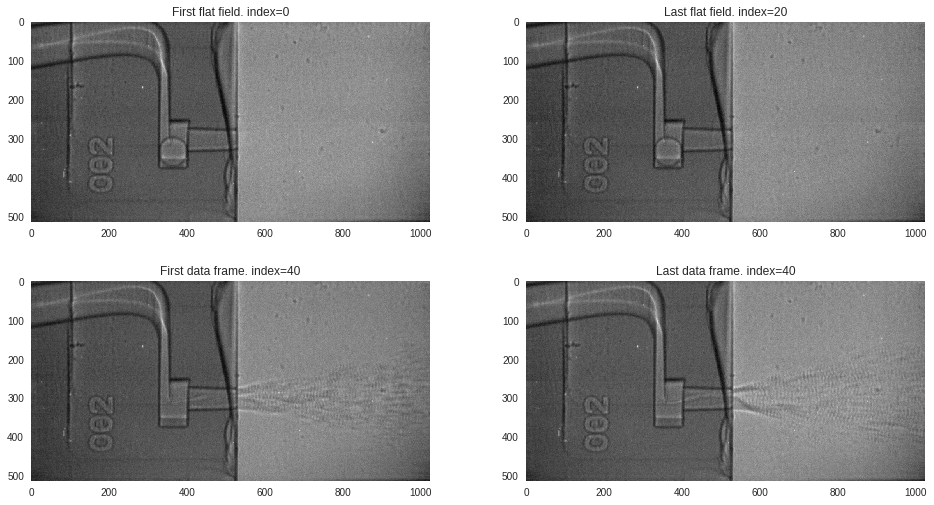

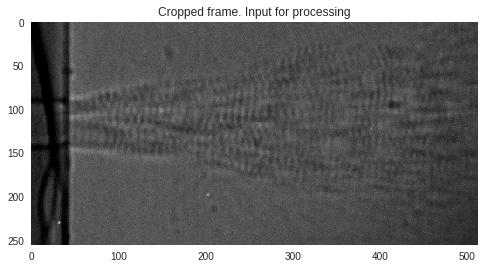

In [197]:

# Input image sequence
path_input = '/mntdirect/_data_visitor/me1516/id19/Phantom/Glasduese_TestA/'
file_name = '17.2_2_3_10xNUV_A_.tif'

#------------------------------
# Dataset settings
#------------------------------

dataset = '17.2_2_3_10xNUV_A_'
region = 'all'

start         = 0
end           = 120
shots_num     = 1

flats_start   = 0
flats_end     = 20

start_spray   = 40
seq_length    = 80-1

# Region of interest
x0 = 487             # <----- ADJUST
y0 = 184             # <----- ADJUST
w  = 512
h  = 256

# Read multi-tiff
flats = []
flats_low_pass = []

max_read_images = end

print('Reading source multi-tiff...')
images = read_tiff(path_input + file_name, max_read_images)
images = images[start: end+1]
print('OK')
print('Number of images: {}'.format(len(images)))


check_data_frames()

## Step 2: Start processing

In [198]:

process_sequence()


Dataset: 17.2_2_3_10xNUV_A_
Input file: 17.2_2_3_10xNUV_A_.tif
Processing...


100%|██████████| 79/79 [01:52<00:00,  1.43s/it]


Finished


## Step 3: Analyse results

Analysis...
512
[  0 100 200 300 400 500]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
OK


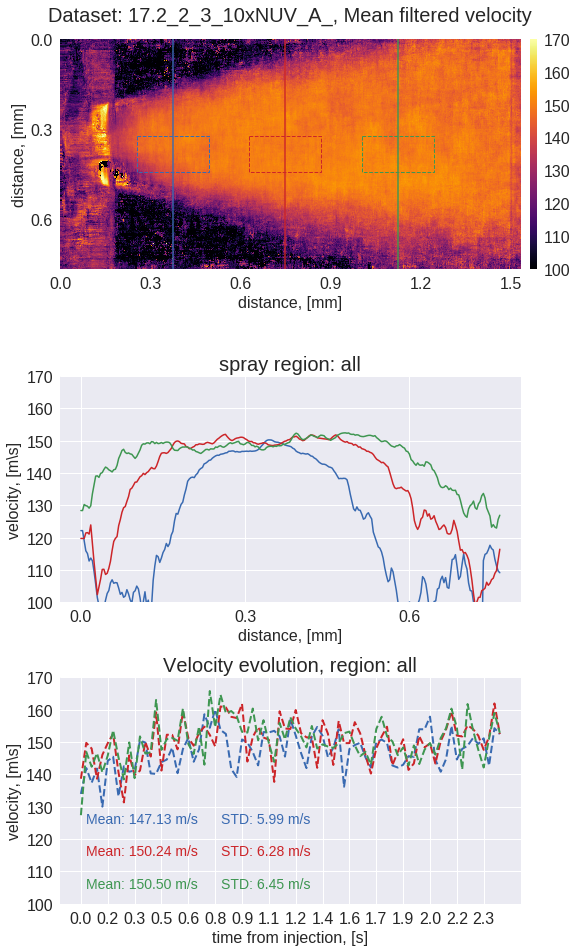

In [168]:

amp, corr = make_analysis_figure()
plot_metrics()

In [63]:
print amp.shape

(80, 256, 512)


# Testing scripts

In [68]:
#images = read_images_from_directory(path_input, start, end)
#print(len(images))

(128, 250)


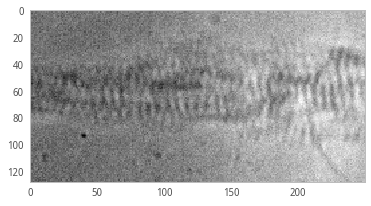

In [42]:


frame_n = 2

im = images[frame_n]
flat = images[89]

# Crop frame
im = im[y0:y0+h, x0:x0+w]
flat = flat[y0:y0+h, x0:x0+w]

print(im.shape)
plt.imshow(im, cmap='gray')
plt.show()

(128, 250)


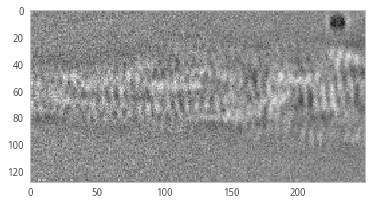

In [43]:
#flat_input = im_res

im = np.log((flat.astype(float)  + 0.001) / (im.astype(float)  + 0.001))

print(im.shape)
plt.imshow(im, cmap='gray')
plt.show()

im_res = Image.fromarray(im)
#im_res.save(path_flow_input + input_frame_file)
#np.save(im, path_flow_input + input_frame_file, dtype = np.float32 )
im.astype('float32').tofile(path_flow_input + input_frame_file)

In [66]:


counter = 0

os.system('rm ' + output_path+'*')

command = [exec_path + corr_exec, path_flow_input + input_frame_file , str(w), str(h), str(counter).zfill(3), output_path]
#command = ['rm', output_path+'corr-coeff-250-128.raw']
#print(command)

subprocess.check_output(command)
#subprocess.check_output([exec_path + flow_exec, '/users/opid19/dev/flow/settings.xml'])


'CUDA Device: GeForce GTX 1080 Ti. Launch timeout: Yes\n//----------------------------------------------------------------------//\n//        2D Correlation flow (Test) using NVIDIA CUDA. Version 0.5\t   \n//                                                                        \n//           Author: Alexey Ershov. <ershov.alexey@gmail.com>             \n//            Karlsruhe Institute of Technology. 2018                     \n//----------------------------------------------------------------------//\nAllocating memory on the device...\nAvailable\t:\t10990MB / 11172MB\nWidth: 250\nPitch: 256\n\nExtended Width: 5000\nExtended Pitch: 5120\nNeeded (approx.):\t100MB\nDevice containers:\n1108332249088\n1108384677888\nAllocated\t:\t100MB\nInitialization of cuda operations...\nCUDA Correlation 2D: OK\nCUDA Add 2D       : OK\n\nStarting correlation flow computation...\nShared memory: 49152 Needed: 5184 \nPitch: 5120\nGrid dim:313 160\nWidth:5000\nHeight:2560\nTotal GPU computation time:  0.

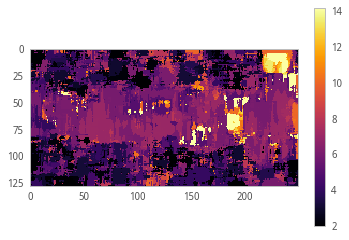

In [49]:
# Read Correlation result
#w = 128
#h = 128

amp_file_name = output_path+'corr-amp-'+str(w)+'-'+str(h)+'.raw'
amp = read_raw_image(amp_file_name, (h,w))

plt.imshow(amp, cmap='inferno')
plt.colorbar()
plt.show()

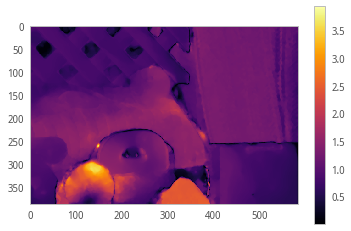

In [43]:
# Read Optical flow result
u_file_name = output_path+'flow-u-'+str(w)+'-'+str(h)+'.raw'
v_file_name = output_path+'flow-v-'+str(w)+'-'+str(h)+'.raw'

u,v = read_flow_from_components(u_file_name, v_file_name, (h,w))

amp = np.sqrt(u**2 + v**2)
plt.imshow(amp, cmap='inferno')
plt.colorbar()
plt.show()

In [102]:
client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect('firewall.esrf.fr', port='5022', username='me1516', password='Fnx43+37')

NameError: name 'paramiko' is not defined

In [4]:
stdin, stdout, stderr = client.exec_command('ls')

In [85]:
stdin2, stdout2, stderr2 = client.exec_command('ls')

In [5]:
for line in stdout:
    print(line.strip('\n'))

for line in stderr:
    print(line.strip('\n'))

id19


In [ ]:
channel = client.invoke_shell()
stdin = channel.makefile('wb')
stdout = channel.makefile('rb')

stdin.write('''
cd id19/flow
cat Makefile
exit
''')


In [ ]:
print(stdout.read())

In [70]:
for line in stdout:
    print(line.strip('\n'))

TypeError: a bytes-like object is required, not 'str'

In [ ]:
client.close()